# LSTM

In [113]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, r2_score

In [114]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [115]:
torch.cuda.is_available()

True

In [116]:
device

device(type='cuda')

In [117]:
!nvidia-smi

Wed Oct 23 13:57:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   46C    P8              6W /   80W |    1127MiB /   8188MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Define DataSet

In [118]:

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, input_cols, seq_length=4):
        self.data = data
        self.target_col = target_col
        self.input_cols = input_cols
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.input_cols].iloc[idx:idx+self.seq_length].values
        y = self.data[self.target_col].iloc[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define the LSTM model

In [119]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [120]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays_indoor_person_counts.csv')

In [121]:
df.keys()

Index(['DateTime', 'electricity_15min_diff', 'heating_15min_diff',
       'is_holiday', 'day_of_week', 'hour_of_day', 'is_working_hour',
       'number_of_people', 'Temperature', 'Humidity', 'Dewpoint',
       'Sun Duration', 'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [122]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)


In [123]:
df

,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,True,5,0,False,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 00:15:00,1.38,5.0,True,5,0,False,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 00:30:00,1.20,5.0,True,5,0,False,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 00:45:00,1.37,5.0,True,5,0,False,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 01:00:00,1.15,5.0,True,5,1,False,0,13.1,87.0,11.0,0.0,0.0,4.8,240.0,13.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,True,5,23,False,0,16.9,50.0,6.4,0.0,0.0,8.2,190.0,16.9,0.0
2022-12-31 23:15:00,1.64,2.0,True,5,23,False,0,16.9,50.0,6.4,0.0,0.0,8.2,190.0,16.9,0.0
2022-12-31 23:30:00,1.87,3.0,True,5,23,False,0,16.9,50.0,6.4,0.0,0.0,8.2,190.0,16.9,0.0


In [124]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

# Task1: Predict the heating_15min_diff using the weather data

## using weather data as features

In [125]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [126]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [127]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')



Epoch [1/100], avg_epoch_mse_loss:: 5.6389
Epoch [2/100], avg_epoch_mse_loss:: 2.6313
Epoch [3/100], avg_epoch_mse_loss:: 2.5468
Epoch [4/100], avg_epoch_mse_loss:: 2.4739
Epoch [5/100], avg_epoch_mse_loss:: 2.4362
Epoch [6/100], avg_epoch_mse_loss:: 2.4181
Epoch [7/100], avg_epoch_mse_loss:: 2.3918
Epoch [8/100], avg_epoch_mse_loss:: 2.3824
Epoch [9/100], avg_epoch_mse_loss:: 2.3812
Epoch [10/100], avg_epoch_mse_loss:: 2.3824
Epoch [11/100], avg_epoch_mse_loss:: 2.3655
Epoch [12/100], avg_epoch_mse_loss:: 2.3457
Epoch [13/100], avg_epoch_mse_loss:: 2.3487
Epoch [14/100], avg_epoch_mse_loss:: 2.3494
Epoch [15/100], avg_epoch_mse_loss:: 2.3242
Epoch [16/100], avg_epoch_mse_loss:: 2.3185
Epoch [17/100], avg_epoch_mse_loss:: 2.3192
Epoch [18/100], avg_epoch_mse_loss:: 2.3046
Epoch [19/100], avg_epoch_mse_loss:: 2.3064
Epoch [20/100], avg_epoch_mse_loss:: 2.3047
Epoch [21/100], avg_epoch_mse_loss:: 2.2808
Epoch [22/100], avg_epoch_mse_loss:: 2.2802
Epoch [23/100], avg_epoch_mse_loss:: 2.28

In [128]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs).to(device)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test  mse Loss: 3.9719
Test RSME Loss: 1.9930
Test MAE: 1.6198
Test R² Score: 0.1767


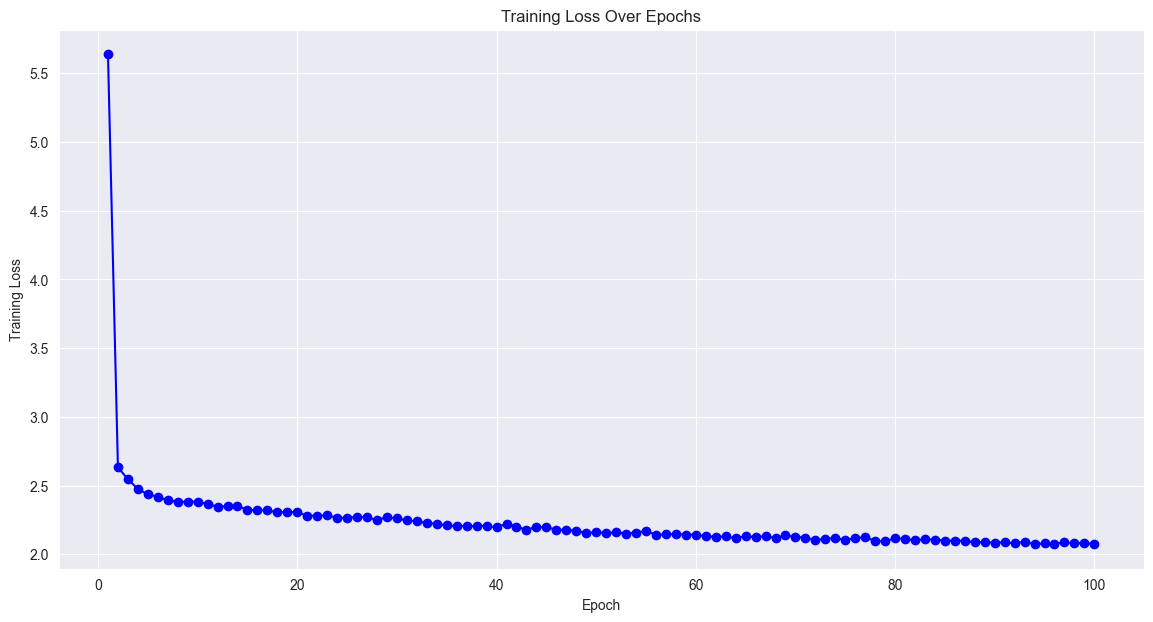

In [129]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

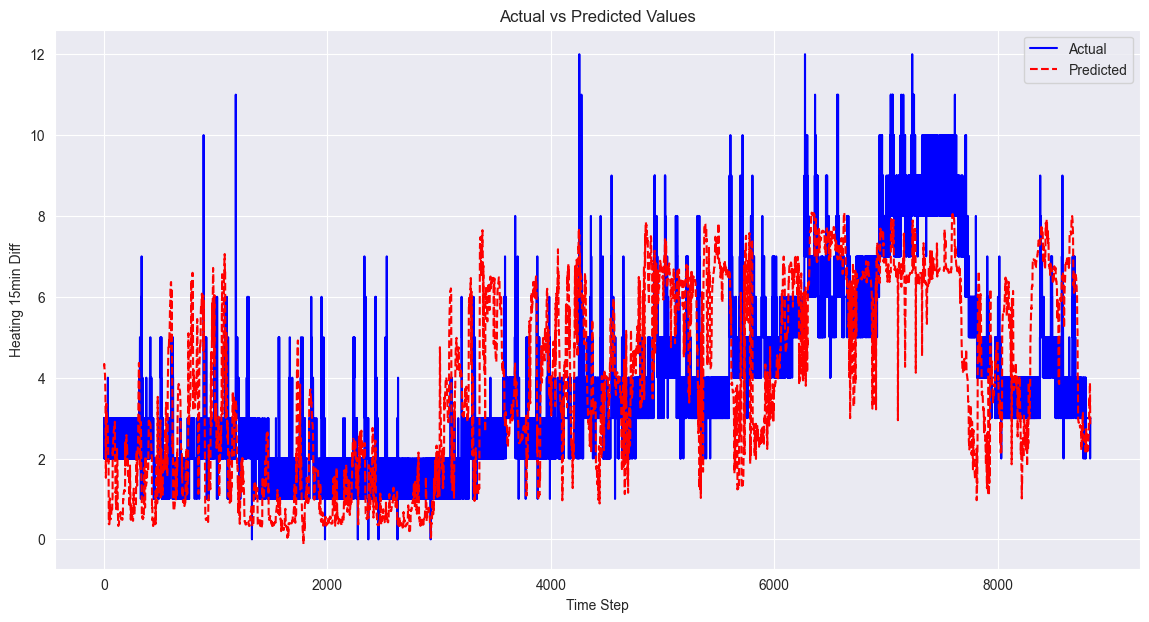

In [130]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Using data with holidays

In [131]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays.csv')

In [132]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [133]:
df

,electricity_15min_diff,heating_15min_diff,is_holiday,day_of_week,hour_of_day,is_working_hour,number_of_people,Temperature,Humidity,Dewpoint,Sun Duration,Precipitation Height,Wind Speed,Wind Direction,indoor_temperature,temperature_difference
DateTime,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.00,0.0,1,5,0,0,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 00:15:00,1.38,5.0,1,5,0,0,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 00:30:00,1.20,5.0,1,5,0,0,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 00:45:00,1.37,5.0,1,5,0,0,0,13.2,85.0,10.7,0.0,0.0,5.0,240.0,13.2,0.0
2022-01-01 01:00:00,1.15,5.0,1,5,1,0,0,13.1,87.0,11.0,0.0,0.0,4.8,240.0,13.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:00:00,2.12,3.0,1,5,23,0,0,16.9,50.0,6.4,0.0,0.0,8.2,190.0,16.9,0.0
2022-12-31 23:15:00,1.64,2.0,1,5,23,0,0,16.9,50.0,6.4,0.0,0.0,8.2,190.0,16.9,0.0
2022-12-31 23:30:00,1.87,3.0,1,5,23,0,0,16.9,50.0,6.4,0.0,0.0,8.2,190.0,16.9,0.0


In [134]:
df.keys()

Index(['electricity_15min_diff', 'heating_15min_diff', 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference'],
      dtype='object')

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35041 entries, 2022-01-01 00:00:00 to 2023-01-01 00:00:00
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   electricity_15min_diff  35041 non-null  float64
 1   heating_15min_diff      35041 non-null  float64
 2   is_holiday              35041 non-null  int32  
 3   day_of_week             35041 non-null  int32  
 4   hour_of_day             35041 non-null  int32  
 5   is_working_hour         35041 non-null  int32  
 6   number_of_people        35041 non-null  int64  
 7   Temperature             35041 non-null  float64
 8   Humidity                35041 non-null  float64
 9   Dewpoint                35041 non-null  float64
 10  Sun Duration            35041 non-null  float64
 11  Precipitation Height    35041 non-null  float64
 12  Wind Speed              35041 non-null  float64
 13  Wind Direction          35041 non-null  float64
 14  ind

In [136]:
df.index.name

'DateTime'

In [137]:
# df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# df.set_index('DateTime', inplace=True)

In [138]:

# Ensure all columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [139]:
# Drop rows with NaN values that may have been introduced by coercion
df.dropna(inplace=True)

In [140]:
# Define the date ranges for training and test data
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

In [141]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [142]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [143]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')


Epoch [1/100], avg_epoch_mse_loss:: 6.3787
Epoch [2/100], avg_epoch_mse_loss:: 2.5610
Epoch [3/100], avg_epoch_mse_loss:: 2.4506
Epoch [4/100], avg_epoch_mse_loss:: 2.3733
Epoch [5/100], avg_epoch_mse_loss:: 2.3076
Epoch [6/100], avg_epoch_mse_loss:: 2.2807
Epoch [7/100], avg_epoch_mse_loss:: 2.2570
Epoch [8/100], avg_epoch_mse_loss:: 2.2371
Epoch [9/100], avg_epoch_mse_loss:: 2.2099
Epoch [10/100], avg_epoch_mse_loss:: 2.1968
Epoch [11/100], avg_epoch_mse_loss:: 2.1764
Epoch [12/100], avg_epoch_mse_loss:: 2.1566
Epoch [13/100], avg_epoch_mse_loss:: 2.1501
Epoch [14/100], avg_epoch_mse_loss:: 2.1507
Epoch [15/100], avg_epoch_mse_loss:: 2.1227
Epoch [16/100], avg_epoch_mse_loss:: 2.1233
Epoch [17/100], avg_epoch_mse_loss:: 2.1359
Epoch [18/100], avg_epoch_mse_loss:: 2.0916
Epoch [19/100], avg_epoch_mse_loss:: 2.0945
Epoch [20/100], avg_epoch_mse_loss:: 2.0771
Epoch [21/100], avg_epoch_mse_loss:: 2.0542
Epoch [22/100], avg_epoch_mse_loss:: 2.0495
Epoch [23/100], avg_epoch_mse_loss:: 2.04

In [144]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')


Test mse Loss: 3.5865
Test RSME Loss: 1.8938
Test MAE: 1.5449
Test R² Score: 0.2568


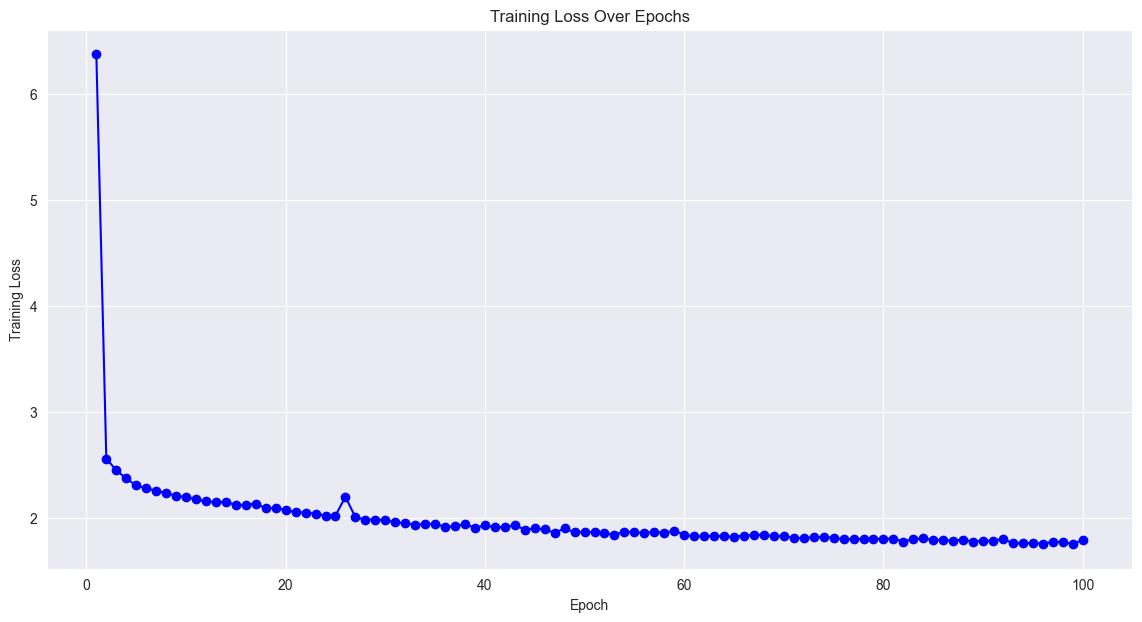

In [145]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

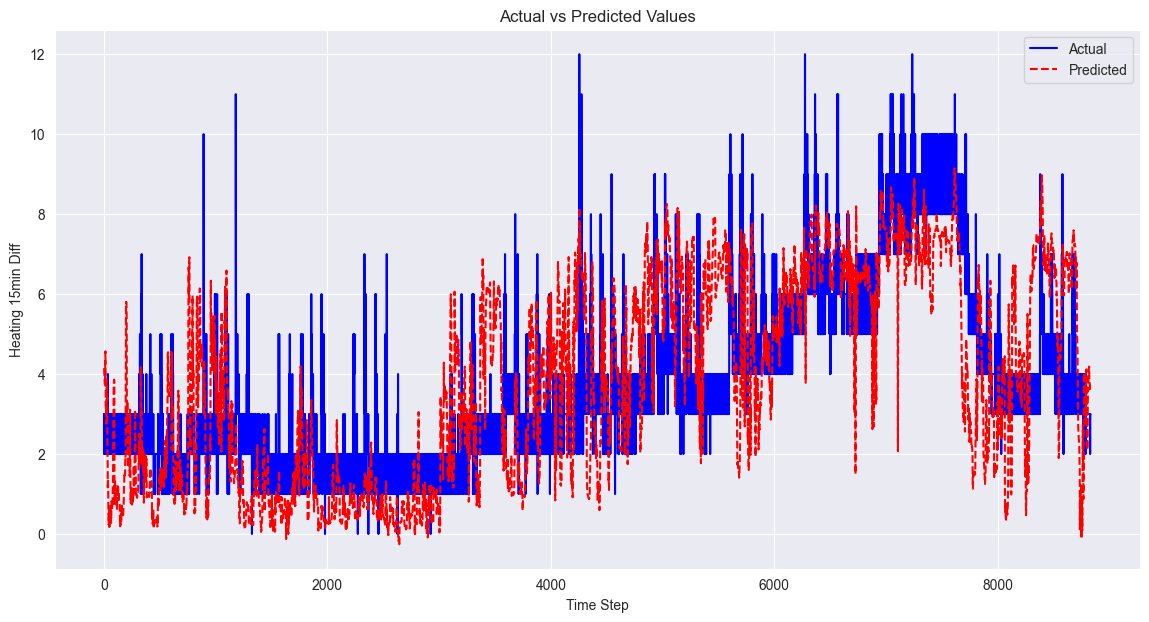

In [146]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [147]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'heating_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [148]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [149]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')


Epoch [1/100], avg_epoch_mse_loss:: 6.1592
Epoch [2/100], avg_epoch_mse_loss:: 2.5821
Epoch [3/100], avg_epoch_mse_loss:: 2.4344
Epoch [4/100], avg_epoch_mse_loss:: 2.3422
Epoch [5/100], avg_epoch_mse_loss:: 2.3015
Epoch [6/100], avg_epoch_mse_loss:: 2.2635
Epoch [7/100], avg_epoch_mse_loss:: 2.2352
Epoch [8/100], avg_epoch_mse_loss:: 2.2404
Epoch [9/100], avg_epoch_mse_loss:: 2.2252
Epoch [10/100], avg_epoch_mse_loss:: 2.2061
Epoch [11/100], avg_epoch_mse_loss:: 2.1827
Epoch [12/100], avg_epoch_mse_loss:: 2.1727
Epoch [13/100], avg_epoch_mse_loss:: 2.1625
Epoch [14/100], avg_epoch_mse_loss:: 2.1451
Epoch [15/100], avg_epoch_mse_loss:: 2.1332
Epoch [16/100], avg_epoch_mse_loss:: 2.1545
Epoch [17/100], avg_epoch_mse_loss:: 2.1549
Epoch [18/100], avg_epoch_mse_loss:: 2.1131
Epoch [19/100], avg_epoch_mse_loss:: 2.1011
Epoch [20/100], avg_epoch_mse_loss:: 2.0976
Epoch [21/100], avg_epoch_mse_loss:: 2.0794
Epoch [22/100], avg_epoch_mse_loss:: 2.0669
Epoch [23/100], avg_epoch_mse_loss:: 2.05

In [150]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 4.2491
Test RSME Loss: 2.0613
Test MAE: 1.7135
Test R² Score: 0.1194


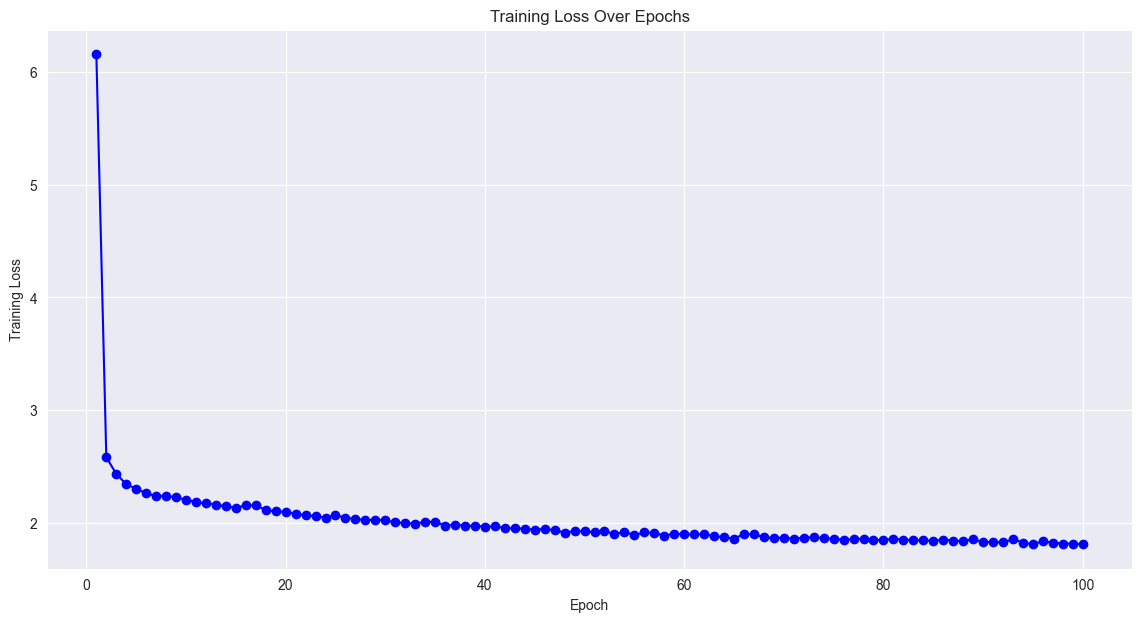

In [151]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

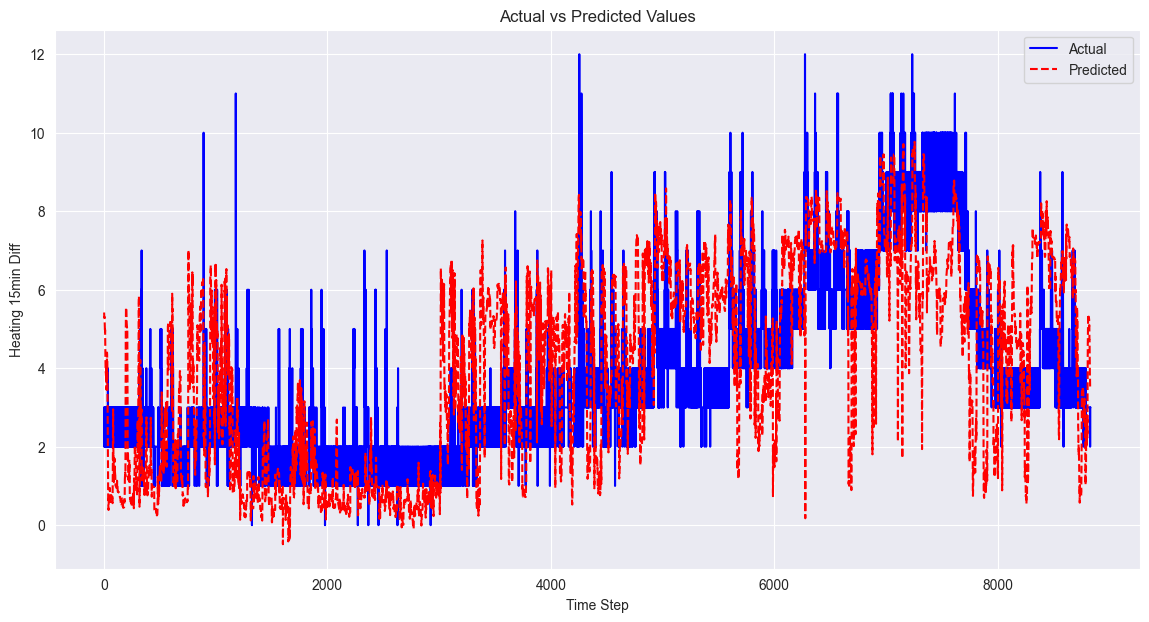

In [152]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Task2: electricity_15min_diff

## using weather data as features

In [153]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [154]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [155]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.4379
Epoch [2/100], avg_epoch_mse_loss:: 11.0838
Epoch [3/100], avg_epoch_mse_loss:: 11.0804
Epoch [4/100], avg_epoch_mse_loss:: 11.0638
Epoch [5/100], avg_epoch_mse_loss:: 11.0712
Epoch [6/100], avg_epoch_mse_loss:: 11.0398
Epoch [7/100], avg_epoch_mse_loss:: 11.0427
Epoch [8/100], avg_epoch_mse_loss:: 11.0360
Epoch [9/100], avg_epoch_mse_loss:: 11.0318
Epoch [10/100], avg_epoch_mse_loss:: 11.0412
Epoch [11/100], avg_epoch_mse_loss:: 11.0395
Epoch [12/100], avg_epoch_mse_loss:: 11.0309
Epoch [13/100], avg_epoch_mse_loss:: 11.0170
Epoch [14/100], avg_epoch_mse_loss:: 11.0108
Epoch [15/100], avg_epoch_mse_loss:: 11.0132
Epoch [16/100], avg_epoch_mse_loss:: 11.0019
Epoch [17/100], avg_epoch_mse_loss:: 11.0110
Epoch [18/100], avg_epoch_mse_loss:: 10.9929
Epoch [19/100], avg_epoch_mse_loss:: 10.9912
Epoch [20/100], avg_epoch_mse_loss:: 10.9883
Epoch [21/100], avg_epoch_mse_loss:: 10.9873
Epoch [22/100], avg_epoch_mse_loss:: 10.9938
Epoch [23/100], avg

In [156]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 1.0698
Test RSME Loss: 1.0343
Test MAE: 0.7426
Test R² Score: -0.0772


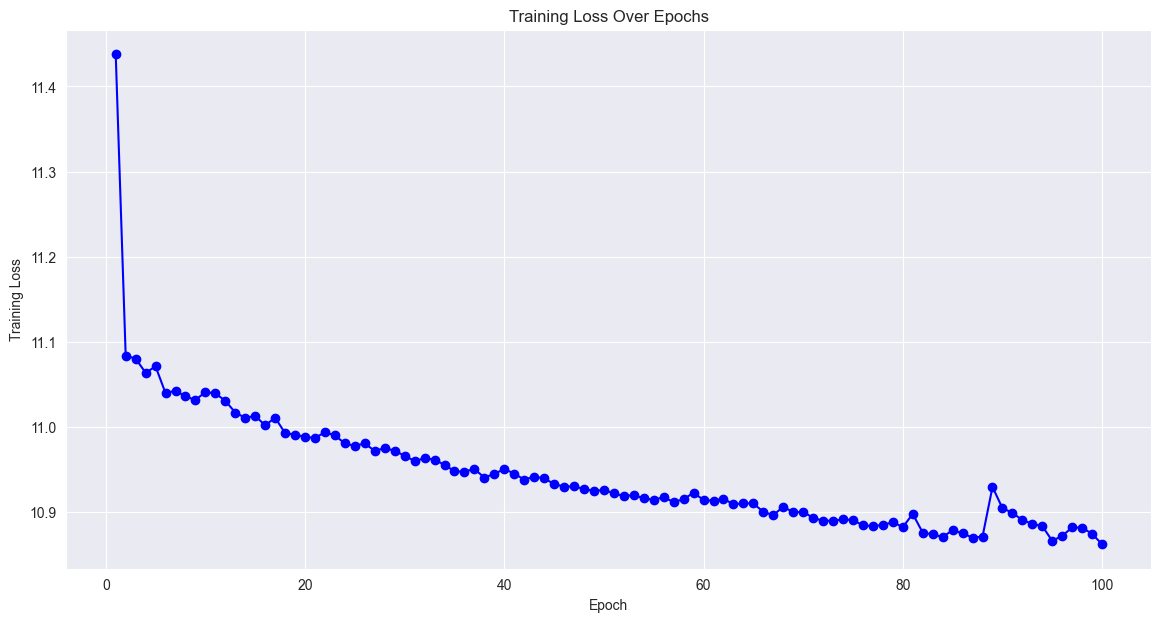

In [157]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

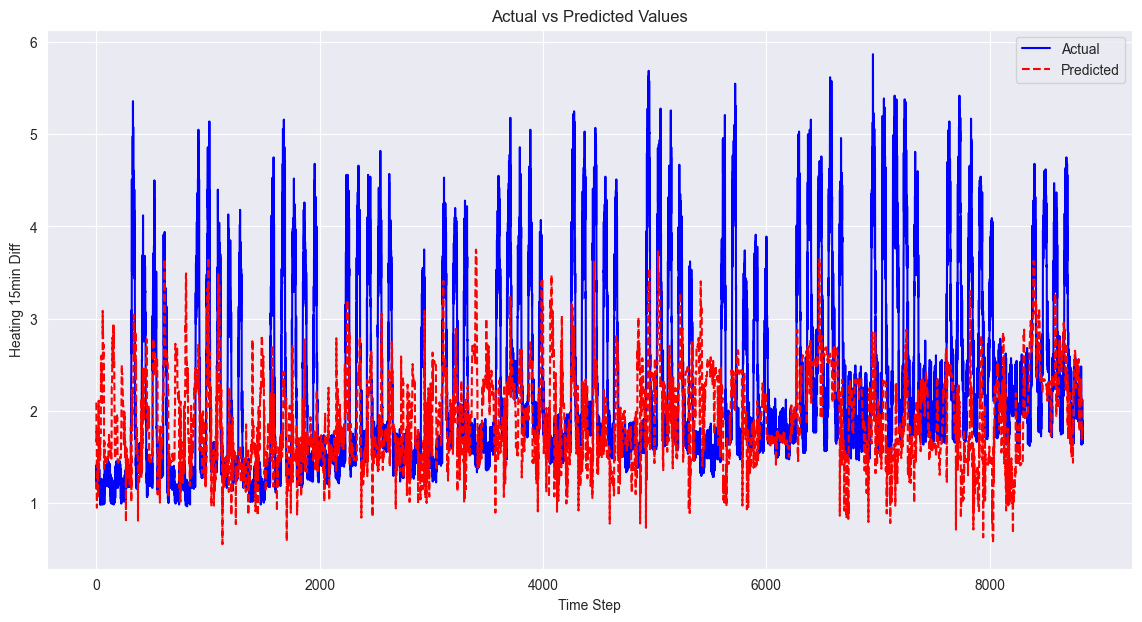

In [158]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using data with holidays

In [159]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'electricity_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [160]:

input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [161]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.1737
Epoch [2/100], avg_epoch_mse_loss:: 10.8026
Epoch [3/100], avg_epoch_mse_loss:: 10.6920
Epoch [4/100], avg_epoch_mse_loss:: 10.6072
Epoch [5/100], avg_epoch_mse_loss:: 10.7541
Epoch [6/100], avg_epoch_mse_loss:: 10.6043
Epoch [7/100], avg_epoch_mse_loss:: 10.6115
Epoch [8/100], avg_epoch_mse_loss:: 10.5864
Epoch [9/100], avg_epoch_mse_loss:: 10.5296
Epoch [10/100], avg_epoch_mse_loss:: 10.5416
Epoch [11/100], avg_epoch_mse_loss:: 10.4925
Epoch [12/100], avg_epoch_mse_loss:: 10.4795
Epoch [13/100], avg_epoch_mse_loss:: 10.5138
Epoch [14/100], avg_epoch_mse_loss:: 10.5018
Epoch [15/100], avg_epoch_mse_loss:: 10.4880
Epoch [16/100], avg_epoch_mse_loss:: 10.5139
Epoch [17/100], avg_epoch_mse_loss:: 10.4715
Epoch [18/100], avg_epoch_mse_loss:: 10.4690
Epoch [19/100], avg_epoch_mse_loss:: 10.4547
Epoch [20/100], avg_epoch_mse_loss:: 10.4548
Epoch [21/100], avg_epoch_mse_loss:: 10.4483
Epoch [22/100], avg_epoch_mse_loss:: 10.4366
Epoch [23/100], avg

In [162]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 0.3626
Test RSME Loss: 0.6022
Test MAE: 0.4632
Test R² Score: 0.6374


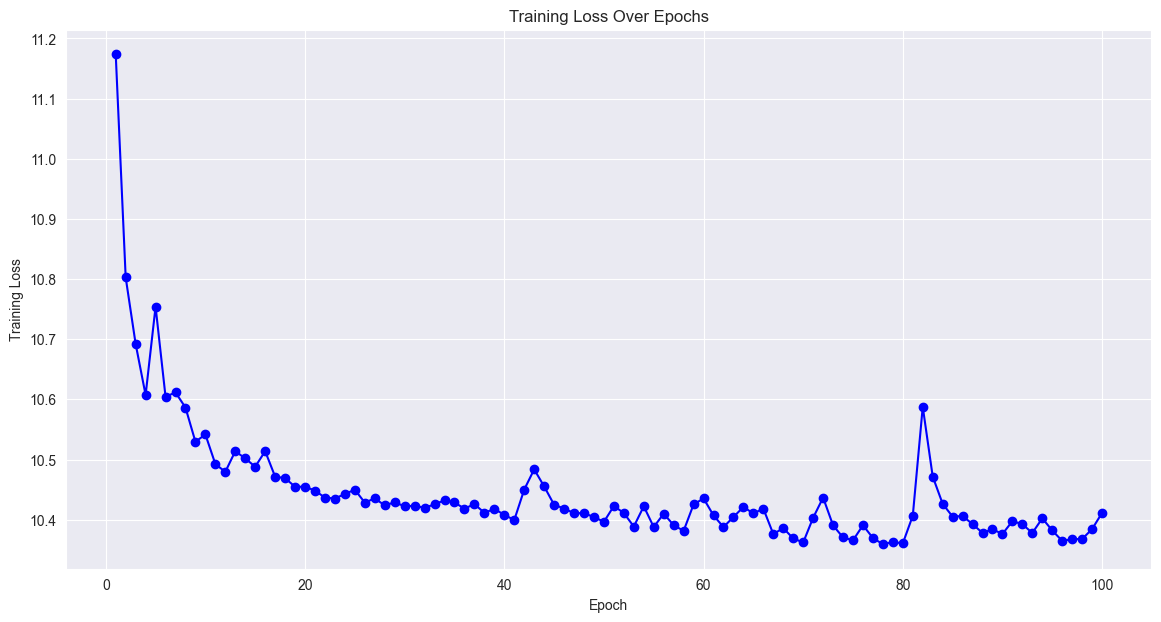

In [163]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

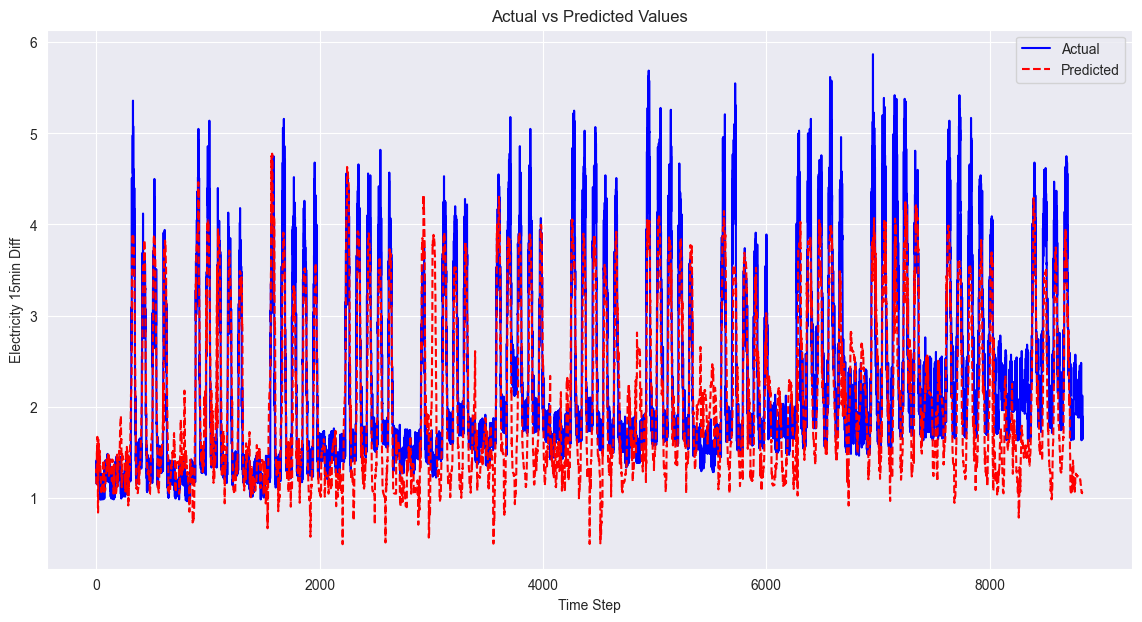

In [164]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using inddors features

In [165]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'electricity_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [166]:
input_size = len(input_cols)
hidden_size = 20
output_size = 1
num_layers = 1
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [167]:
train_losses = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss:: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss:: 11.0536
Epoch [2/100], avg_epoch_mse_loss:: 10.7180
Epoch [3/100], avg_epoch_mse_loss:: 10.7055
Epoch [4/100], avg_epoch_mse_loss:: 10.6749
Epoch [5/100], avg_epoch_mse_loss:: 10.6452
Epoch [6/100], avg_epoch_mse_loss:: 10.6247
Epoch [7/100], avg_epoch_mse_loss:: 10.6100
Epoch [8/100], avg_epoch_mse_loss:: 10.5976
Epoch [9/100], avg_epoch_mse_loss:: 10.5817
Epoch [10/100], avg_epoch_mse_loss:: 10.5753
Epoch [11/100], avg_epoch_mse_loss:: 10.5622
Epoch [12/100], avg_epoch_mse_loss:: 10.5536
Epoch [13/100], avg_epoch_mse_loss:: 10.5445
Epoch [14/100], avg_epoch_mse_loss:: 10.5361
Epoch [15/100], avg_epoch_mse_loss:: 10.5207
Epoch [16/100], avg_epoch_mse_loss:: 10.5105
Epoch [17/100], avg_epoch_mse_loss:: 10.5045
Epoch [18/100], avg_epoch_mse_loss:: 10.4976
Epoch [19/100], avg_epoch_mse_loss:: 10.4999
Epoch [20/100], avg_epoch_mse_loss:: 10.4879
Epoch [21/100], avg_epoch_mse_loss:: 10.4813
Epoch [22/100], avg_epoch_mse_loss:: 10.4870
Epoch [23/100], avg

In [168]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    

# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test mse Loss: 0.3555
Test RSME Loss: 0.5962
Test MAE: 0.4457
Test R² Score: 0.6435


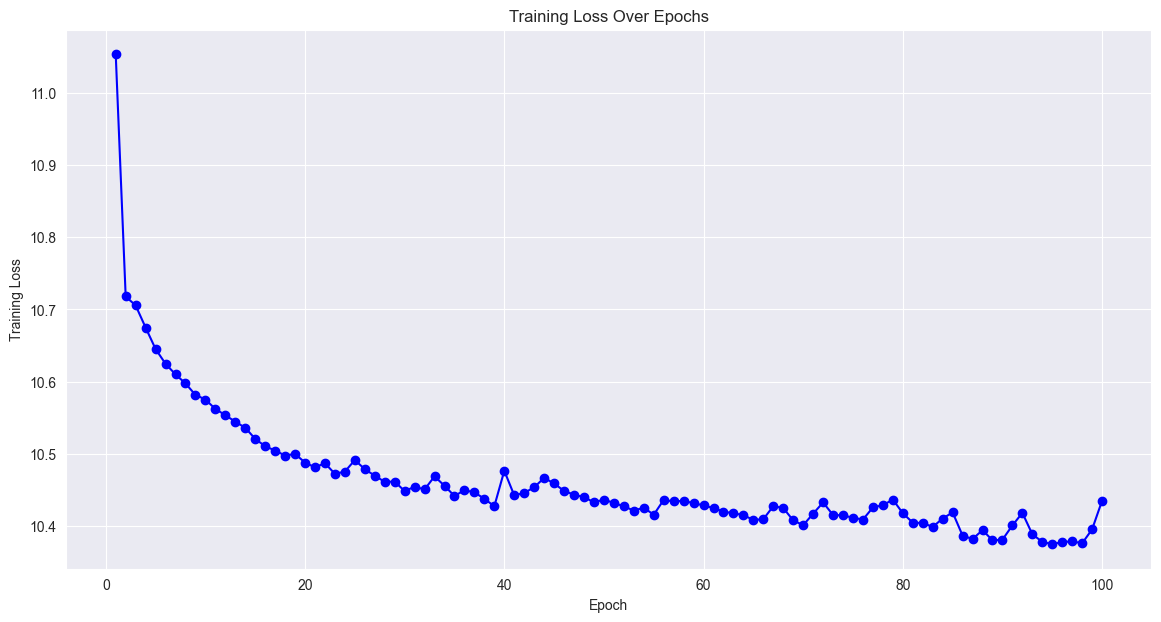

In [169]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

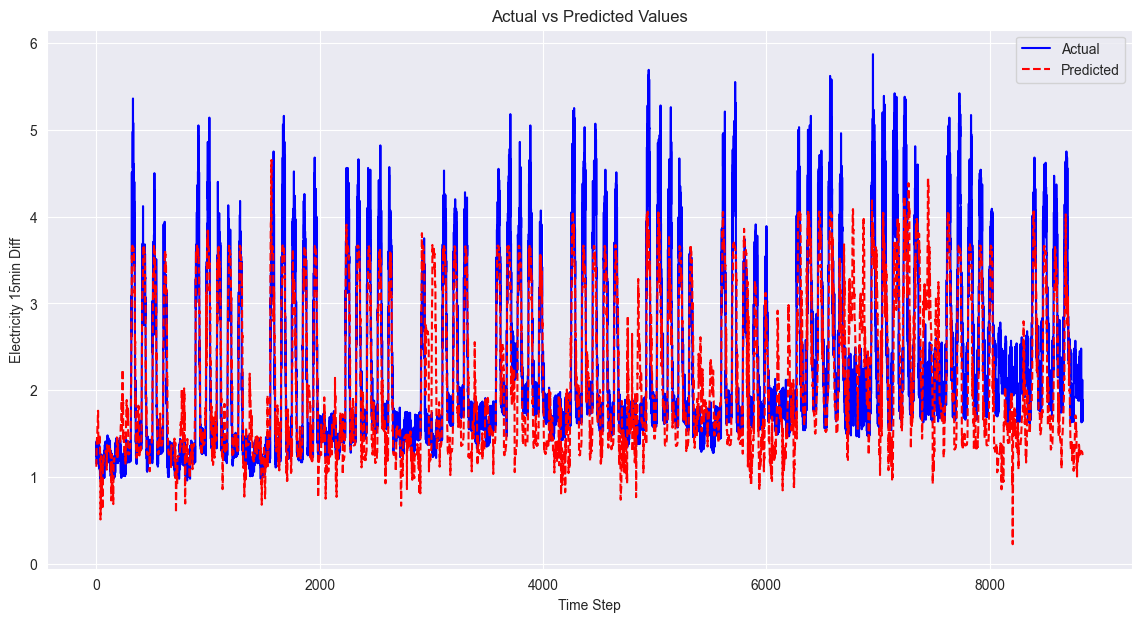

In [170]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Electricity 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()